In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from trading_bot.data_collector import get_stock_data
from trading_bot.data_processor import (
    load_data,
    add_technical_indicators,
    save_processed_data,
    clean_data,
    normalize_data,
)
from trading_bot.tasks import run_backtest

In [2]:
get_stock_data("MSFT", "5d", save_to_csv=True, interval="15m")

Data saved to data/raw/MSFT_5d.csv


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-10-07 09:30:00-04:00,416.000000,417.109985,414.609985,414.809998,1982937,0.0,0.0
2024-10-07 09:45:00-04:00,414.890015,415.494995,414.200012,414.670013,775392,0.0,0.0
2024-10-07 10:00:00-04:00,414.700012,415.755005,414.660004,415.750000,646320,0.0,0.0
2024-10-07 10:15:00-04:00,415.739990,416.190002,415.440002,415.820007,547617,0.0,0.0
2024-10-07 10:30:00-04:00,415.829987,416.369995,415.450012,415.553986,443640,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-11 14:45:00-04:00,415.250000,415.739990,415.209991,415.730011,333334,0.0,0.0
2024-10-11 15:00:00-04:00,415.747711,416.140015,415.649994,415.920013,337159,0.0,0.0
2024-10-11 15:15:00-04:00,415.924988,416.165497,415.790009,416.149994,280750,0.0,0.0


In [3]:


ticker = "MSFT"
period = "5d"
data = load_data(ticker, period)
data = add_technical_indicators(data)
data = clean_data(data)
data = normalize_data(data)
save_processed_data(data, ticker, period)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
data = pd.read_csv(
    "data/processed/MSFT_1y_processed.csv",
    parse_dates=["Datetime"],
    index_col="Datetime",
)
data.head()
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 2023-08-01 09:30:00-04:00 to 2023-11-28 15:30:00-05:00
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               584 non-null    float64
 1   High               584 non-null    float64
 2   Low                584 non-null    float64
 3   Close              584 non-null    float64
 4   Volume             584 non-null    int64  
 5   Dividends          584 non-null    float64
 6   Stock Splits       584 non-null    float64
 7   SMA_5              580 non-null    float64
 8   RSI                570 non-null    float64
 9   MACD               559 non-null    float64
 10  MACD_Signal        551 non-null    float64
 11  MACD_Histogram     551 non-null    float64
 12  BollingerB_Lower   580 non-null    float64
 13  BollingerB_Middle  580 non-null    float64
 14  BollingerB_Upper   580 non-null    float64
 15  EMA                575 non-null  

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
SMA_5                 4
RSI                  14
MACD                 25
MACD_Signal          33
MACD_Histogram       33
BollingerB_Lower      4
BollingerB_Middle     4
BollingerB_Upper      4
EMA                   9
dtype: int64

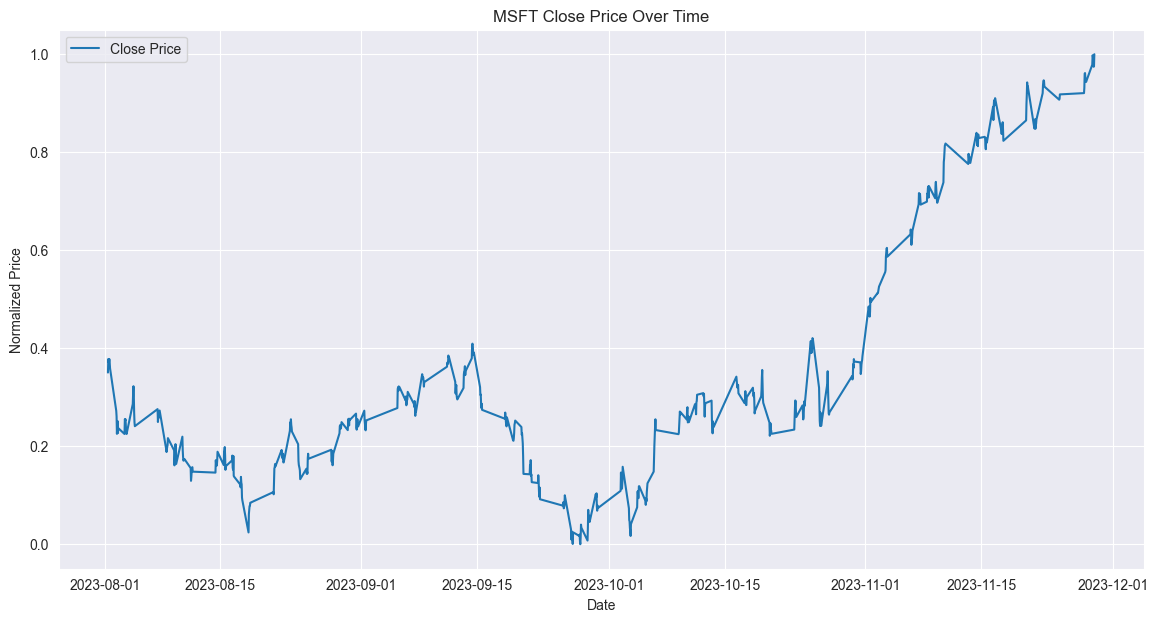

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(data["Close"], label="Close Price")
plt.title("MSFT Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

This represent the Close Price of the stock market. The task is to visualize the basic stock data.

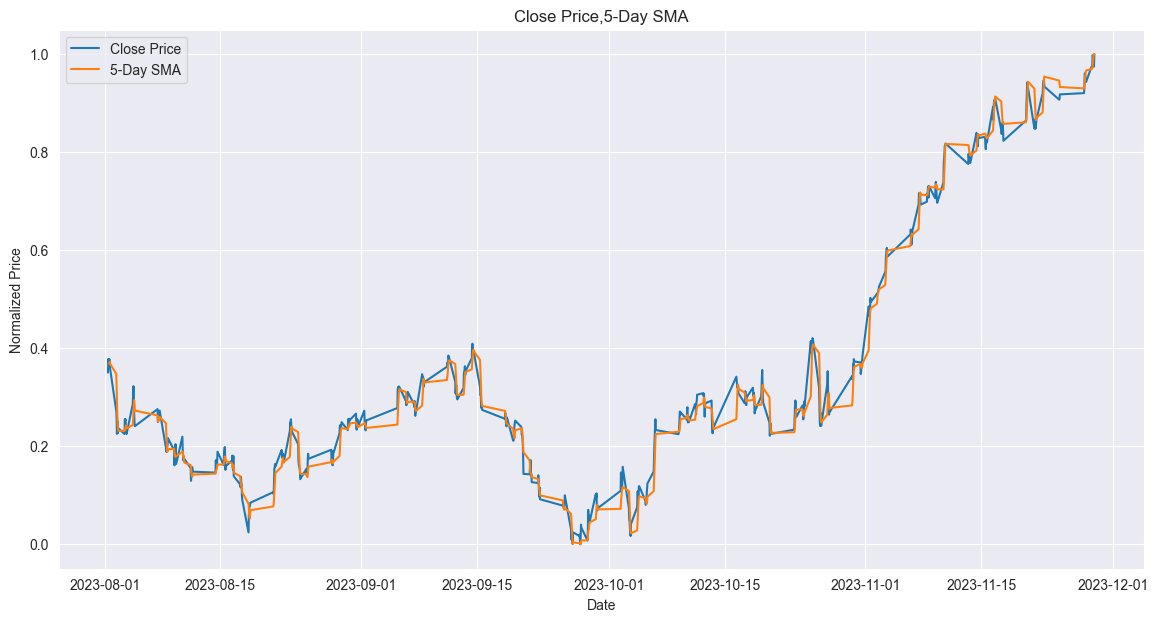

In [7]:
# Plot SMA
plt.figure(figsize=(14, 7))

plt.plot(data["Close"], label="Close Price")
plt.plot(data["SMA_5"], label="5-Day SMA")

plt.title("Close Price,5-Day SMA")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

The SMA (Simple Moving Average) is a technical indicator that shows the average price of a stock over a period of time. The SMA is calculated by adding the closing prices of the stock for a period of time and then dividing by the number of days in that period. The SMA is used to identify trends in the stock market and to help traders make decisions about when to buy or sell a stock.

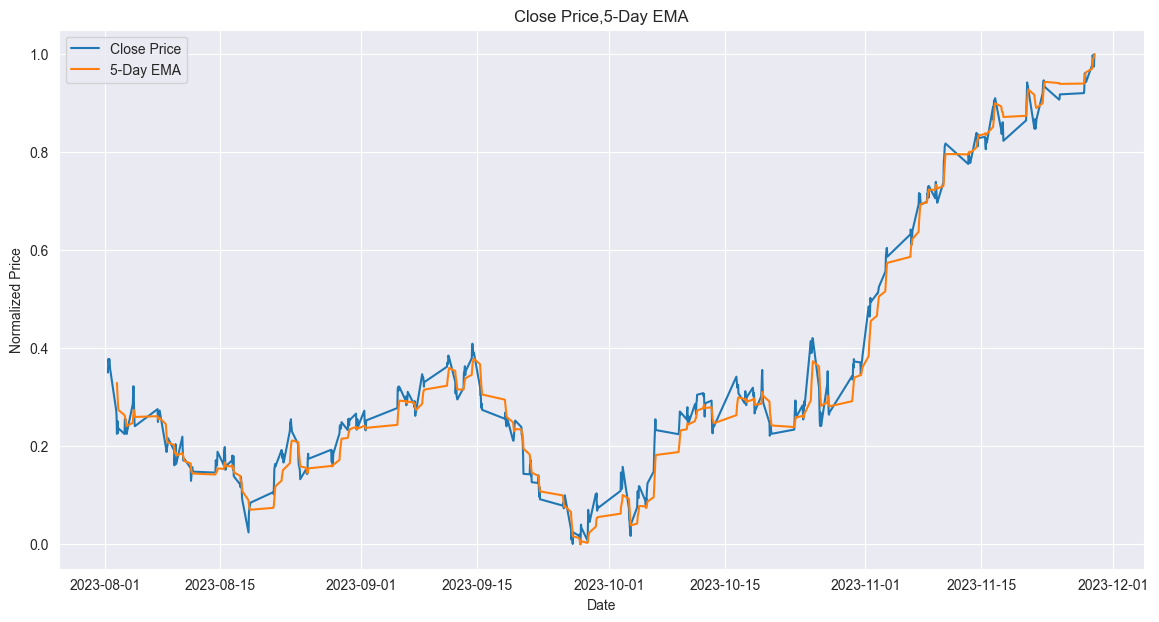

In [8]:
# Plot EMA
plt.figure(figsize=(14, 7))

plt.plot(data["Close"], label="Close Price")
plt.plot(data["EMA"], label="5-Day EMA")

plt.title("Close Price,5-Day EMA")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

The EMA (Exponential Moving Average) is a technical indicator that is similar to the SMA, but it gives more weight to the most recent prices. The EMA is calculated by taking the closing prices of the stock for a period of time and then multiplying them by a weight factor that decreases over time. The EMA is used to identify trends in the stock market and to help traders make decisions about when to buy or sell a stock.

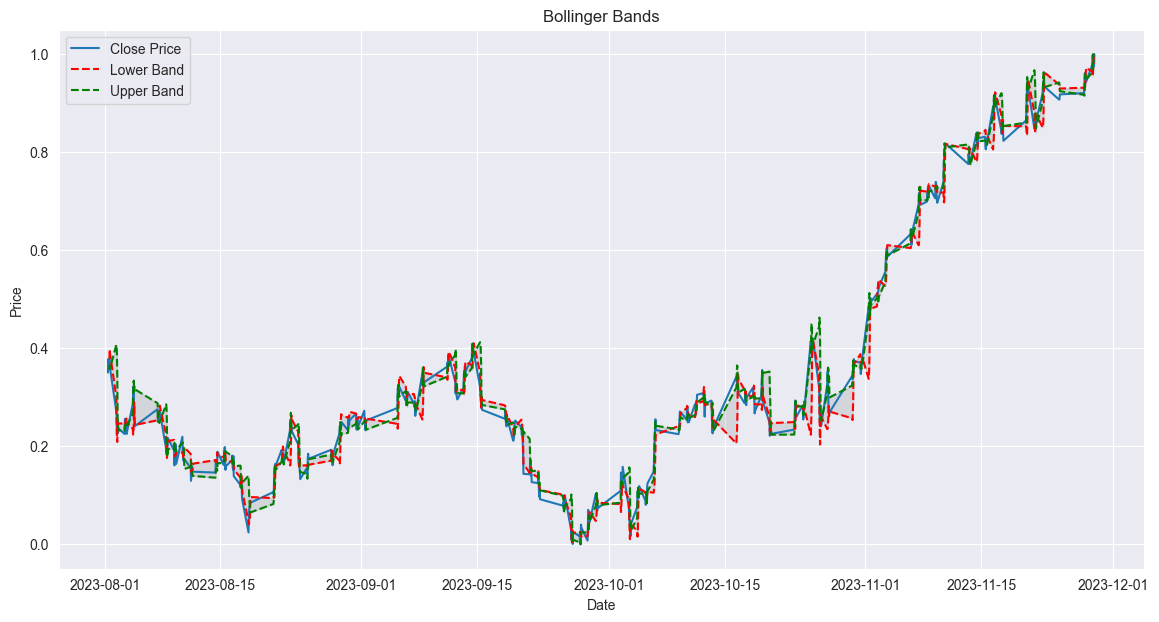

In [9]:
# Bollinger Bands
plt.figure(figsize=(14, 7))

plt.fill_between(
    data.index,
    data["BollingerB_Lower"],
    data["BollingerB_Upper"],
    color="gray",
    alpha=0.2, 
)
plt.plot(data["Close"], label="Close Price")
plt.plot(data["BollingerB_Lower"], linestyle="--", color="red", label="Lower Band")
plt.plot(data["BollingerB_Upper"], linestyle="--", color="green", label="Upper Band")

plt.title("Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

The Bollinger Bands are a technical indicator that shows the volatility of a stock. The Bollinger Bands are calculated by taking the SMA of the stock and then adding and subtracting a multiple of the standard deviation of the stock. The Bollinger Bands are used to identify when a stock is overbought or oversold and to help traders make decisions about when to buy or sell a stock.

In [14]:
start_date = "2022-08-01"
end_date = "2024-01-30"
compare_start = "2024-02-01"
compare_end = "2024-03-28"
initial_cash = 10000

run_backtest(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    compare_start=compare_start,
    compare_end=compare_end,
    initial_cash=initial_cash,
    interval="1d",
)

Running backtest for MSFT from 2022-08-01 to 2024-03-28 00:00:00-04:00...
Data saved to data/raw/MSFT_2022-08-01_2024-03-28 00:00:00-04:00.csv
Percentage Return: 0.006815491432225827%
Max Drawdown: -0.002128338881329546%
Sharpe Ratio: 0.17474611097989448
Sortino Ratio: 0.3767519539010329
Transaction History: [{'action': 'sell', 'price': 0.10896023347295236, 'amount': 1, 'date': Timestamp('2023-10-02 09:30:00-0400', tz='America/New_York')}, {'action': 'sell', 'price': 0.14629404730055337, 'amount': 1, 'date': Timestamp('2023-10-02 10:30:00-0400', tz='America/New_York')}, {'action': 'buy', 'price': 0.11338469108128933, 'amount': 1, 'date': Timestamp('2023-10-02 11:30:00-0400', tz='America/New_York')}, {'action': 'buy', 'price': 0.11296988499364076, 'amount': 1, 'date': Timestamp('2023-10-02 12:30:00-0400', tz='America/New_York')}, {'action': 'buy', 'price': 0.1136615097928839, 'amount': 1, 'date': Timestamp('2023-10-02 13:30:00-0400', tz='America/New_York')}, {'action': 'sell', 'price': 